In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
from tqdm import tqdm
import gdal 

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import cv2

from PIL import Image
from sklearn.preprocessing import MinMaxScaler

from spectral import *
from skimage import io

import matplotlib.pyplot as plt
%matplotlib inline
#READ A TIFF IMAGE
#img = io.imread(tiff_loc + f)
#img_color = get_rgb(img, [2, 1, 0])

In [18]:
input_loc = 'input/'
train_files = 'train-tif-v2/'
test_files = 'test-tif-v2/'
tiff_loc_train = input_loc+train_files
tiff_loc_test = input_loc+test_files
df_train = pd.read_csv(input_loc + 'train_v2.csv')
print("locations variables created")

locations variables created


In [19]:
#TIFF exploration
from osgeo import gdal
gtif = gdal.Open(tiff_loc_train + 'train_3394.tif')
print(gtif.GetMetadata())
band_names = ['b','g','r','nir']
#Visualizing the bands in value based data
print("Band Counts: ", gtif.RasterCount)
for band in range( gtif.RasterCount ):
    band += 1
    srcband = gtif.GetRasterBand(band)
    stats = srcband.GetStatistics( True, True )
    print("band: %s\n Min=%.0f\n Max=%.0f\n Mean=%.0f\n StdDev=%.3f" % (
                band_names[band-1], stats[0], stats[1], stats[2], stats[3] ))

{'TIFFTAG_DATETIME': '2017:04:26 23:16:06', 'TIFFTAG_IMAGEDESCRIPTION': '{"shape": [256, 256, 4]}', 'TIFFTAG_SOFTWARE': 'tifffile.py'}
Band Counts:  4
band: b
 Min=5125
 Max=6039
 Mean=5585
 StdDev=97.897
band: g
 Min=4377
 Max=5257
 Mean=4734
 StdDev=104.625
band: r
 Min=2892
 Max=3845
 Mean=3246
 StdDev=104.223
band: nir
 Min=4582
 Max=10250
 Mean=7174
 StdDev=795.252


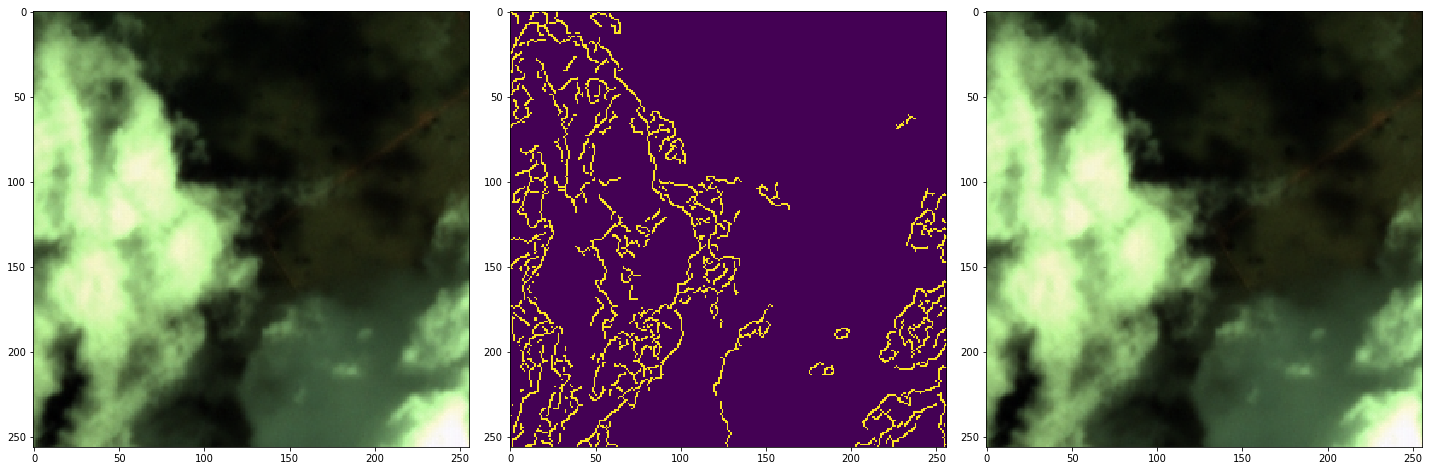

In [20]:
#properly display images exploration
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
from matplotlib import image as mimage
%matplotlib inline

img = io.imread(tiff_loc_train + 'train_4440.tif')
img_rgb = get_rgb(img, [2,1,0])

#Rescaling is necessary for edge detection
img_rescale = np.reshape(img_rgb, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 255))
img_rescale = scaler.fit_transform(img_rescale) # .astype(np.float32)
img_rescale = (np.reshape(img_rescale, img_rgb.shape)).astype(np.uint8)
img_rgb_edges = cv2.Canny(img_rescale, 50, 100)

figure, cur_plot = plt.subplots(1, 3, figsize=(20, 20))
cur_plot[0].imshow(img_rgb)
cur_plot[1].imshow(img_rgb_edges)
cur_plot[2].imshow(img_rescale)
figure.subplots_adjust(wspace=0.1)
figure.tight_layout()

In [24]:
import plotly
import plotly.offline as offline
offline.init_notebook_mode(connected=True)
import plotly.graph_objs as pgo
from collections import Counter, defaultdict

labels = df_train['tags'].apply(lambda x: x.split(' '))
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

data=[pgo.Bar(x=list(counts.keys()), y=list(counts.values()))]
layout=dict(height=1024, width=1024, title='Training label Histogram')
fig=dict(data=data, layout=layout)
offline.iplot(data, filename='train-label-dist')

In [5]:
def edge_detection(img_rgb, min_edge, max_edge):
    np.seterr(all='warn')
    img_rescale = np.reshape(img_rgb, (-1, 1))
    scaler = MinMaxScaler(feature_range=(0, 255))
    img_rescale = scaler.fit_transform(img_rescale)
    img_rescale = (np.reshape(img_rescale, img_rgb.shape)).astype(np.uint8)
    img_edges = cv2.Canny(img_rescale, min_edge, max_edge, True)
    return img_edges

def categorization_indexes(img):
    np.seterr(all='warn')
    img_nir = get_rgb(img, [3, 2, 1])
    img_rgb = get_rgb(img, [2, 1, 0])
    
    img_nvdi = (img_nir[:, :, 0] - img_nir[:, :, 1]) / (img_nir[:, :, 0] + img_nir[:, :, 1])
    img_ndwi = (img_nir[:, :, 2] - img_nir[:, :, 0]) / (img_nir[:, :, 2] + img_nir[:, :, 0])
    return img_rgb, img_nvdi, img_ndwi

In [6]:
def create_image_features(img_name, tiff_loc):
    img_loc = img_name+'.tif'
    img = io.imread(tiff_loc+img_loc)
    img_rgb, img_nvdi, img_ndwi = categorization_indexes(img)

    img_rgb_edges = edge_detection(img_rgb, 125, 225)
    spectral_cmap = plt.get_cmap('nipy_spectral')
    img_nvdi = spectral_cmap(img_nvdi)
    img_ndwi = spectral_cmap(img_ndwi)
    
    img_rgb_nvdi_edges = edge_detection(img_nvdi, 150, 200)
    img_rgb_ndwi_edges = edge_detection(img_ndwi, 150, 200)
    
    return {'rgb': img_rgb, 'nvdi': img_nvdi, 'ndwi': img_ndwi, 
            'rgb_edge': img_rgb_edges, 'nvdi_edge': img_rgb_nvdi_edges, 'ndwi_edge': img_rgb_ndwi_edges}


In [7]:
sample_size = 1500
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))
labels.append('name')
label_map = {l: i for i, l in enumerate(labels)}

x_train_rgb = []
x_train_nvdi = []
x_train_ndwi = []
x_train_edges_rgb = []
x_train_edges_nvdi = []
x_train_edges_ndwi = []

y_train = []

sample_train = df_train.sample(n=sample_size)
for img_name, tags in tqdm(sample_train.values, miniters=10):
    img_features = create_image_features(img_name, tiff_loc_train)
    x_train_rgb.append(img_features['rgb'])
    x_train_nvdi.append(img_features['nvdi'])
    x_train_ndwi.append(img_features['ndwi'])
    x_train_edges_rgb.append(img_features['rgb_edge'])
    x_train_edges_nvdi.append(img_features['nvdi_edge'])
    x_train_edges_ndwi.append(img_features['ndwi_edge'])
    
    targets = np.zeros(18)
    for t in tags.split(' '):
        targets[label_map[t]] = 1    
    y_train.append(targets)

  1%|          | 10/1500 [00:00<01:39, 14.95it/s]/Users/figaro/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Users/figaro/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)
  5%|▍         | 70/1500 [00:05<01:51, 12.80it/s]/Users/figaro/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
100%|██████████| 1500/1500 [02:04<00:00, 16.48it/s]


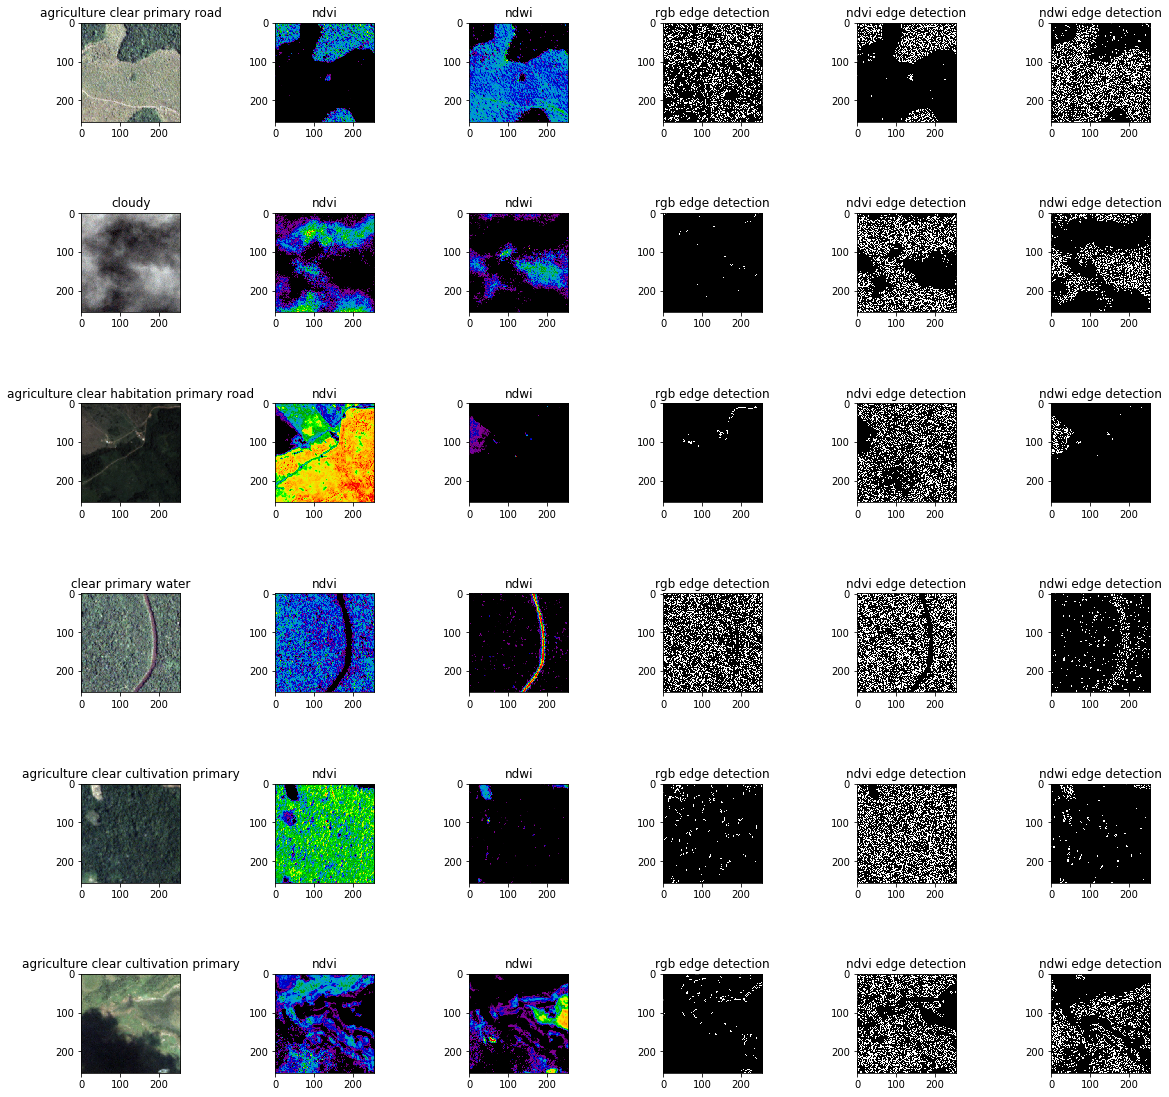

In [12]:
import random

plot_size = 6

sample_start = random.randint(0, sample_size-plot_size)

if plot_size > sample_size:
    plot_size = sample_size

figure, cur_plot = plt.subplots(plot_size, 6, figsize=(16,16))

cis_edge = True
i = 0
for i in range(0,plot_size):
    cur_plot[i, 0].imshow(x_train_rgb[i+sample_start])
    #cur_plot[i, 0].set_title(x_names[i])
    cur_plot[i, 1].imshow(x_train_nvdi[i+sample_start])
    cur_plot[i, 2].imshow(x_train_ndwi[i+sample_start])
    cur_plot[i, 1].imshow(x_train_nvdi[i+sample_start])
    cur_plot[i, 3].imshow(x_train_edges_rgb[i+sample_start], cmap=plt.cm.gray)
    cur_plot[i, 4].imshow(x_train_edges_nvdi[i+sample_start], cmap=plt.cm.gray)
    cur_plot[i, 5].imshow(x_train_edges_ndwi[i+sample_start], cmap=plt.cm.gray)
    
    cur_plot[i, 0].set_title(sample_train.iloc[i+sample_start]['tags'])
    cur_plot[i, 1].set_title('ndvi')
    cur_plot[i, 2].set_title('ndwi')
    cur_plot[i, 3].set_title('rgb edge detection')
    cur_plot[i, 4].set_title('ndvi edge detection')
    cur_plot[i, 5].set_title('ndwi edge detection')

#figure.subplots_adjust(wspace=0.1)
figure.tight_layout()

In [40]:
import scipy.misc

def save_img_feature(img_name, key, img):
    train_folder = input_loc + 'train_jpg_features/'
    im_name = img_name + '_' + key + '.jpg'
    scipy.misc.imsave(train_folder+im_name, img, 'jpeg')

#output image features as jpeg
#process all images and save them in test and train folders
for img_name, tags in tqdm(df_train.values, miniters=500):
    img_features = create_image_features(img_name, tiff_loc_train)
    for key in img_features.keys():
        save_img_feature(img_name, key, img_features[key])
        
    break #adding this so nothing funky happens in the future accidentally

  0%|          | 0/40479 [00:00<?, ?it/s]


In [12]:
from os import listdir
from os.path import isfile, join
import scipy.misc

def save_test_img_feature(img_name, key, img):
    test_folder = input_loc + 'test_jpg_features/'
    im_name = img_name + '_' + key + '.jpg'
    scipy.misc.imsave(test_folder + im_name, img, 'jpeg')

test_file_folder = input_loc + test_files
test_file_list = [f for f in listdir(test_file_folder) if isfile(join(test_file_folder, f))]

for file in tqdm(test_file_list, miniters=750):
    if not '.tif' in file:
        continue
        
    img_name = file.split('.tif')[0]
    img_features = create_image_features(img_name, tiff_loc_test)
    for key in img_features.keys():
        save_test_img_feature(img_name, key, img_features[key])
        
    #break

  0%|          | 0/61191 [00:00<?, ?it/s]/Users/figaro/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Users/figaro/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)
  2%|▏         | 1052/61191 [01:03<1:00:12, 16.65it/s]/Users/figaro/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
100%|██████████| 61191/61191 [59:53<00:00, 16.95it/s]  
